In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 한글 폰트 설정 (Windows 환경 가정, Mac인 경우 'AppleGothic'으로 변경 필요)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [5]:
df = pd.read_csv('model_wideformat_data/GENERAL_Final_Total_Score_WideFormat.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40106 entries, 0 to 40105
Data columns (total 56 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   발급회원번호              40106 non-null  object 
 1   이용건수_신용_B0M_07      40106 non-null  int64  
 2   이용건수_신용_B0M_08      40106 non-null  int64  
 3   이용건수_신용_B0M_09      40106 non-null  int64  
 4   이용건수_신용_B0M_10      40106 non-null  int64  
 5   이용건수_신용_B0M_11      40106 non-null  int64  
 6   이용건수_신용_B0M_12      40106 non-null  int64  
 7   이용금액_신용_B0M_07      40106 non-null  int64  
 8   이용금액_신용_B0M_08      40106 non-null  int64  
 9   이용금액_신용_B0M_09      40106 non-null  int64  
 10  이용금액_신용_B0M_10      40106 non-null  int64  
 11  이용금액_신용_B0M_11      40106 non-null  int64  
 12  이용금액_신용_B0M_12      40106 non-null  int64  
 13  잔액_B0M_07           40106 non-null  float64
 14  잔액_B0M_08           40106 non-null  float64
 15  잔액_B0M_09           40106 non-null  float64
 16  잔액_B

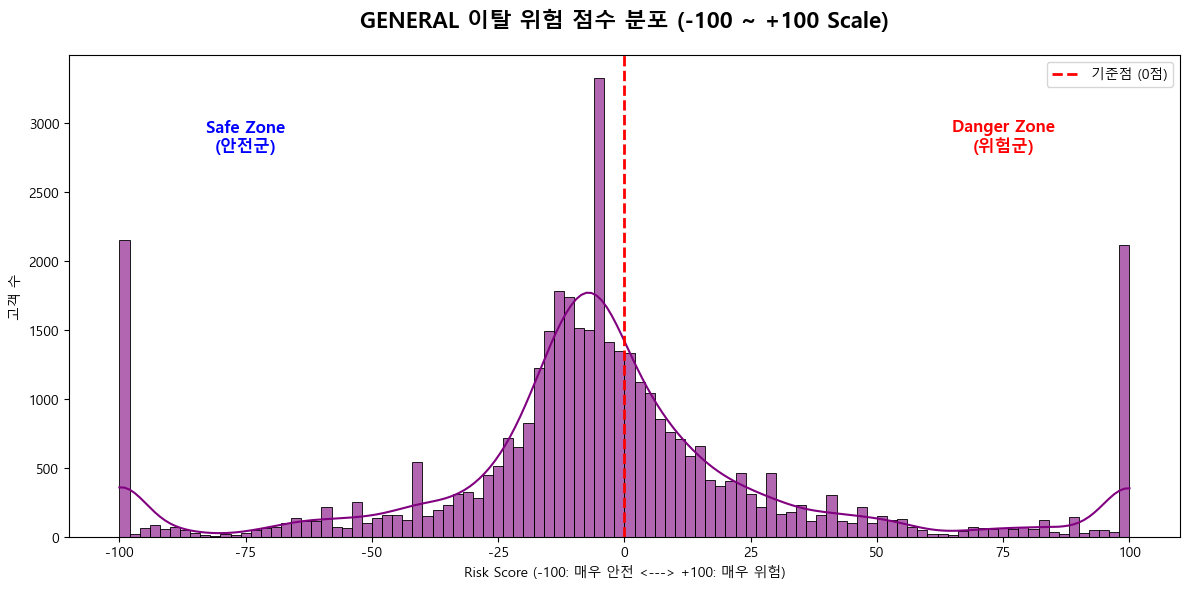

=== 점수 통계 요약 ===
count    40106.000000
mean        -3.544677
std         41.899609
min       -100.000000
25%        -17.549974
50%         -5.854050
75%          9.774570
max        100.000000
Name: Risk_Score_Centered, dtype: float64


In [7]:
# =========================================================
# 가정: df 데이터프레임에 'Final_Total_Score'가 계산되어 있음
# =========================================================

# [Step 1] 이상치 제어 (Clipping) - 필수 과정
# 설명: 극단적인 값(상/하위 1~5%)을 잘라내지 않으면, 스케일링해도 중앙에 다 몰립니다.
lower_limit = df['Final_Total_Score'].quantile(0.05) # 하위 5%
upper_limit = df['Final_Total_Score'].quantile(0.95) # 상위 5%

df['Score_Clipped'] = df['Final_Total_Score'].clip(lower_limit, upper_limit)

# [Step 2] 점수 변환 (Min-Max Scaling -> -100 ~ +100점)
# 설명: 가장 안전한 사람을 -100점, 가장 위험한 사람을 +100점으로 맞춥니다.
scaler = MinMaxScaler(feature_range=(-100, 100))
df['Risk_Score_Centered'] = scaler.fit_transform(df[['Score_Clipped']])

# [Step 3] 시각화 및 검증
plt.figure(figsize=(12, 6))

# 히스토그램 그리기
sns.histplot(df['Risk_Score_Centered'], bins=100, kde=True, color='purple', edgecolor='black', alpha=0.6)

# 기준선(0점) 표시
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='기준점 (0점)')

# 구간 의미 표시 (텍스트)
plt.text(-75, plt.ylim()[1]*0.8, 'Safe Zone\n(안전군)', fontsize=12, color='blue', ha='center', fontweight='bold')
plt.text(75, plt.ylim()[1]*0.8, 'Danger Zone\n(위험군)', fontsize=12, color='red', ha='center', fontweight='bold')

plt.title('GENERAL 이탈 위험 점수 분포 (-100 ~ +100 Scale)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Risk Score (-100: 매우 안전 <---> +100: 매우 위험)')
plt.ylabel('고객 수')
plt.legend()
plt.tight_layout()
plt.show()

# [Step 4] 결과 확인
print("=== 점수 통계 요약 ===")
print(df['Risk_Score_Centered'].describe())

📉 제거되는 최저점(-100) 고객 수: 2044명
📈 제거되는 최고점(+100) 고객 수: 2103명


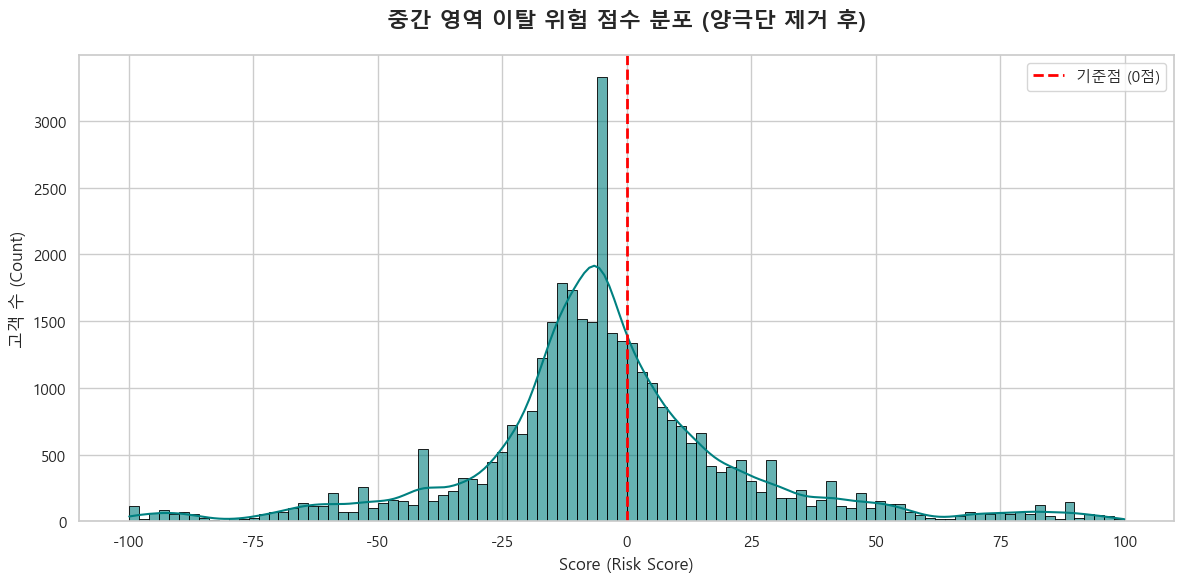


=== 필터링 후 점수 통계 요약 ===
count    35959.000000
mean        -4.117409
std         28.316861
min        -99.893077
25%        -15.865780
50%         -5.874473
75%          6.923283
max         99.879911
Name: Risk_Score_Centered, dtype: float64


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 가정: df에 'Risk_Score_Full_Range' (또는 사용 중인 점수 컬럼)이 존재
# 컬럼명이 다르다면 아래 변수를 수정하세요.
target_col = 'Risk_Score_Centered' 
# =========================================================

# 1. 양극단(-100, 100) 데이터 분리 (제거 전 확인용)
df_min_outlier = df[df[target_col] <= -99.9]
df_max_outlier = df[df[target_col] >= 99.9]

print(f"📉 제거되는 최저점(-100) 고객 수: {len(df_min_outlier)}명")
print(f"📈 제거되는 최고점(+100) 고객 수: {len(df_max_outlier)}명")

# 2. 양극단 제거 (가운데 분포만 남김)
# -99.9점 초과 ~ 99.9점 미만인 데이터만 필터링
df_filtered = df[(df[target_col] > -99.9) & (df[target_col] < 99.9)]

# 3. 분포 재시각화
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid", font="Malgun Gothic")

# 히스토그램 (양극단 제거 후)
sns.histplot(df_filtered[target_col], bins=100, kde=True, color='teal', edgecolor='black', alpha=0.6)

# 0점 기준선
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='기준점 (0점)')

plt.title(f'중간 영역 이탈 위험 점수 분포 (양극단 제거 후)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Score (Risk Score)')
plt.ylabel('고객 수 (Count)')
plt.legend()

plt.tight_layout()
plt.show()

# 4. 필터링된 데이터의 통계 확인
print("\n=== 필터링 후 점수 통계 요약 ===")
print(df_filtered[target_col].describe())

In [ ]:
# df_filtered.to_csv('GENERAL_Final_Risk_Score_Centered_WideFormat.csv', index=False)